# Stock Volatility Modelling with GARCH
### GARCH (Generalized Autoregressive Conditional Heteroskedasticity process) is a popular model for stock volatility due to its ability to handle autocorrelated and non-normal data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go
import yfinance as yf
from arch import arch_model
import statsmodels.api as sm
import probscale

In [2]:
symbol = 'AAPL'
stock = yf.Ticker(symbol)
hist = stock.history(period='MAX', interval='1d')
s_types = {'Open': np.float16}
hist = hist.astype(s_types)
print(hist.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10265 entries, 1980-12-12 to 2021-08-27
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10265 non-null  float16
 1   High          10265 non-null  float64
 2   Low           10265 non-null  float64
 3   Close         10265 non-null  float64
 4   Volume        10265 non-null  int64  
 5   Dividends     10265 non-null  float64
 6   Stock Splits  10265 non-null  float64
dtypes: float16(1), float64(5), int64(1)
memory usage: 581.4 KB
None


In [3]:
# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from datetime import datetime

# options = Options()
# options.headless = True
# url = 'https://finance.yahoo.com/calendar/earnings?symbol=' + symbol
# driver = webdriver.Chrome(executable_path='./chromedriver.exe', options=options)
# driver.get(url)
# earnings = driver.find_elements_by_xpath('/html/body//tbody/tr/td[contains(@aria-label, "Earnings Date")]')

# earning_dates = []

# for e in earnings:
#     date_text = "".join(e.text.split(',')[0:2])
#     earning_dates.append(datetime.strptime(date_text, "%b %d %Y"))


In [4]:
# hist['earnings'] = (hist.index.isin(earning_dates)).astype(int) * 100
# hist.earnings.loc[hist.earnings.shift(-1).eq(100)] = 100
# hist.earnings.loc[hist.earnings.shift(1).eq(100)] = 100
# print(hist.earnings)

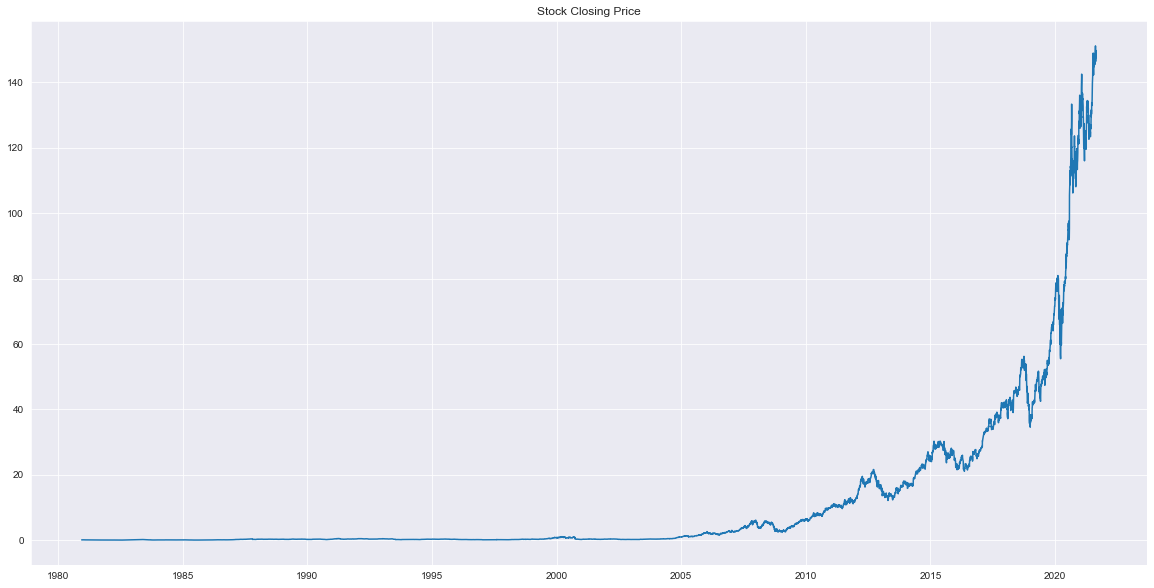

In [5]:
plt.figure(figsize=(20,10))
plt.plot(hist.Close)
plt.title('Stock Closing Price')
# plt.plot(hist.earnings)
plt.show()

## Daily stock returns are used as a proxy for historical volatility

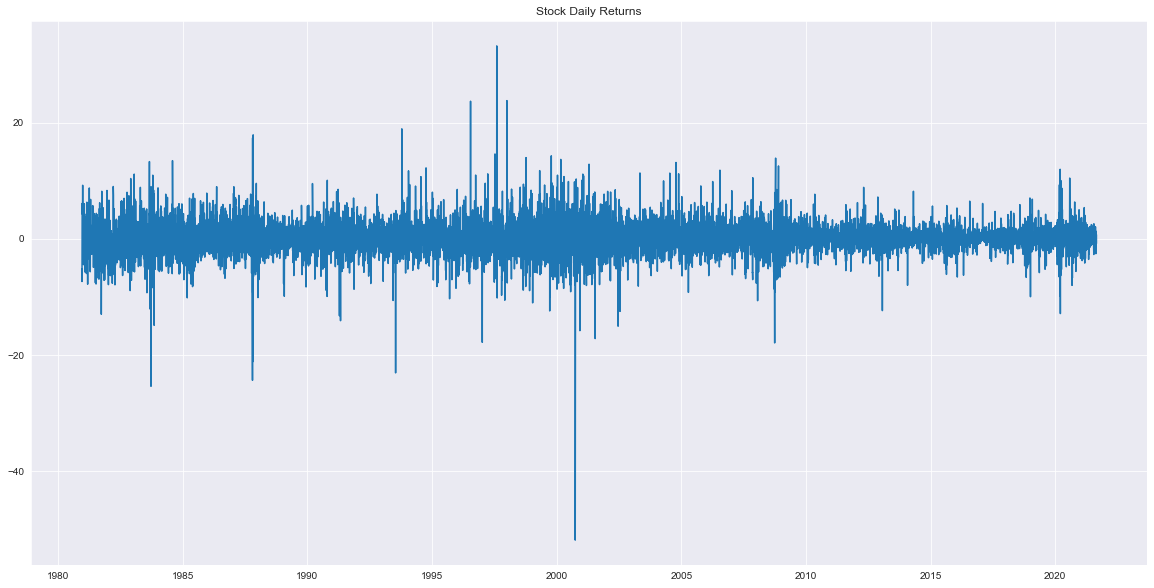

In [6]:
returns = 100 * hist.Close.pct_change().dropna()
plt.figure(figsize=(20,10))
plt.plot(returns)
# plt.plot(hist.earnings)
plt.title('Stock Daily Returns')
plt.show()

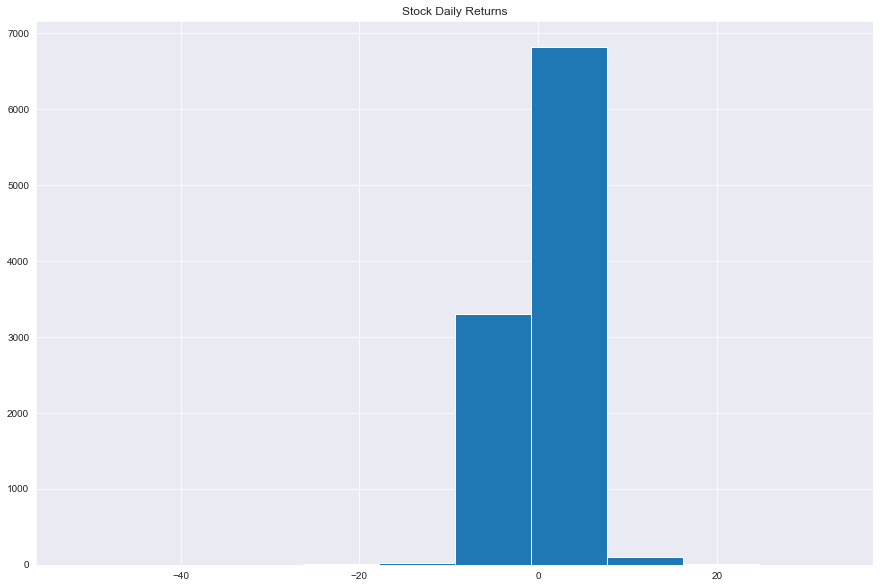

In [7]:
plt.figure(figsize=(15,10))
plt.hist(returns)
plt.title('Stock Daily Returns')
plt.show()

In [8]:
def autocorr_analysis(series, lags):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    sm.graphics.tsa.plot_acf(series, ax=ax1, lags=lags)
    sm.graphics.tsa.plot_pacf(series, ax=ax2, lags=lags)

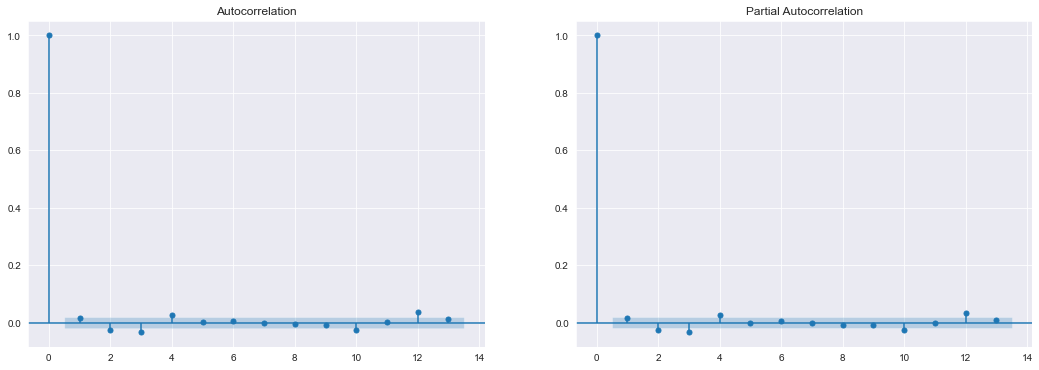

In [9]:
autocorr_analysis(returns, range(14))

### Optimal parameters and type of GARCH are selected based on the average of the AIC and BIC

In [10]:
distributions = ['normal', 'studentst', 'skewt', 'ged']
vol_models = ['GARCH', 'EGARCH', 'ARCH', 'HARCH']
means = ['constant', 'zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX']
o_list = [0,1]
# x = np.array(hist.earnings.iloc[1:])

model = None
best_score = 10000000
for dist in distributions:
    for vol in vol_models:
        for mean in means:
            for o in o_list:
                m = arch_model(returns, vol=vol, p=1, o=o, q=1, dist=dist, mean=mean)
                r = m.fit(disp='off')
                score = (r.bic + r.aic) / 2
                if score < best_score:
                    best_score = score
                    model = m

results = model.fit(disp='off')
print(results.summary())


                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -23485.2
Distribution:      Standardized Skew Student's t   AIC:                           46984.3
Method:                       Maximum Likelihood   BIC:                           47035.0
                                                   No. Observations:                10264
Date:                           Fri, Aug 27 2021   Df Residuals:                    10263
Time:                                   21:46:57   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [11]:
def resid_analysis(residuals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    fig.suptitle('Residual Analysis', fontsize=18)
    ax1.hist(residuals)

    mlb.rc("figure", figsize=(4,4))
    sm.graphics.tsa.plot_acf(residuals, lags=range(1,30), ax=ax2)
    plt.show()

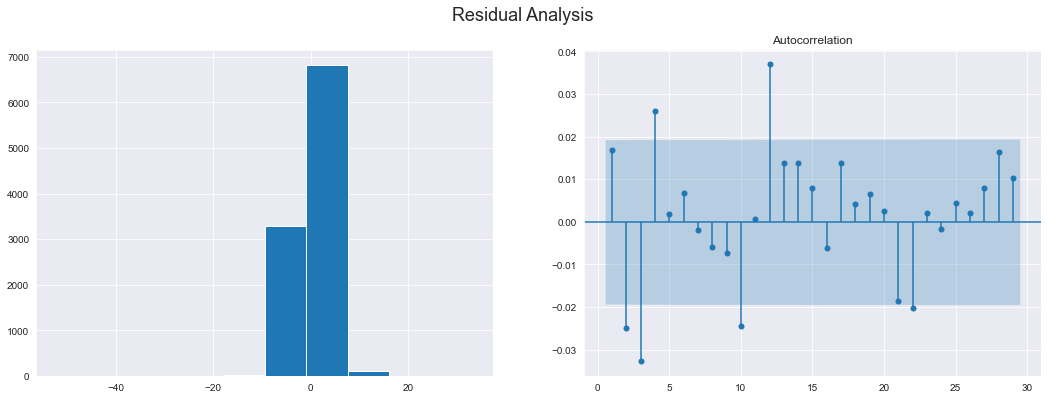

In [12]:
resid_analysis(results.resid)

### The fitted model is used to simulate possible future volatilities
### These simulations create a distribution which can be used for forecasting

In [13]:
horizon = 25
sim_count = 1000
forecasts = results.forecast(horizon=horizon, method='simulation', simulations=sim_count, reindex=True)
sims = forecasts.simulations

In [14]:
# plt.figure(figsize=(20,10))
# lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=.03)
# lines[0].set_label('Simulated paths')
# plt.show()

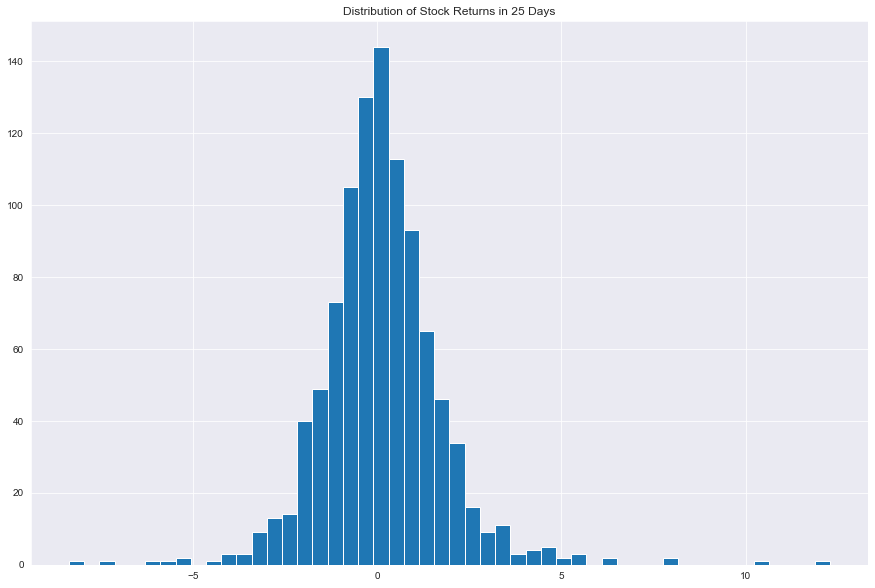

In [15]:
plt.figure(figsize=(15,10))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title(f'Distribution of Stock Returns in {horizon} Days')
plt.show()

In [16]:
print(f'Volatility of forecasted returns: {sims.values[-1].std() * np.sqrt(252)}')

Volatility of forecasted returns: 23.3700551286857


In [17]:
sim_vals = sims.values[-1]
sim_vals = (sim_vals / 100) + 1

starting_price = np.full(shape=(sim_count,1), fill_value=hist.Close.iloc[-1])
sim_vals = np.column_stack((starting_price, sim_vals))
sim_vals = np.cumprod(sim_vals, axis=1)

end_vals = sim_vals[:, -1]

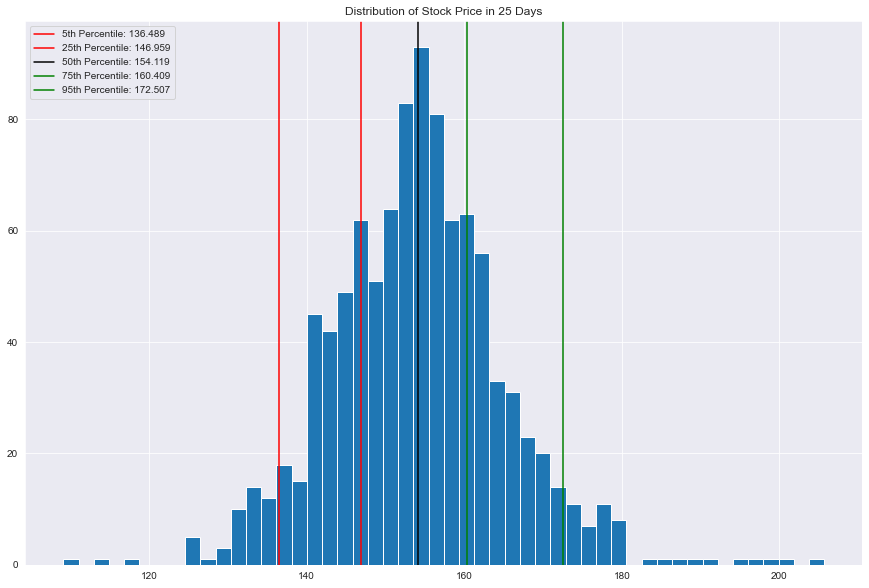

In [18]:
plt.figure(figsize=(15,10))
plt.hist(end_vals,bins=50)

def plot_percentile_prices(price_chart=True):
    for p, c in zip([5, 25, 50, 75, 95], ['red', 'red', 'black', 'green', 'green']):
        p_val = np.percentile(end_vals, p).round(3) if price_chart else p      
        plt.axvline(p_val, label=f'{p}th Percentile: {p_val}', color=c)

plot_percentile_prices()
plt.legend(loc='upper left')
plt.title(f'Distribution of Stock Price in {horizon} Days')
plt.show()


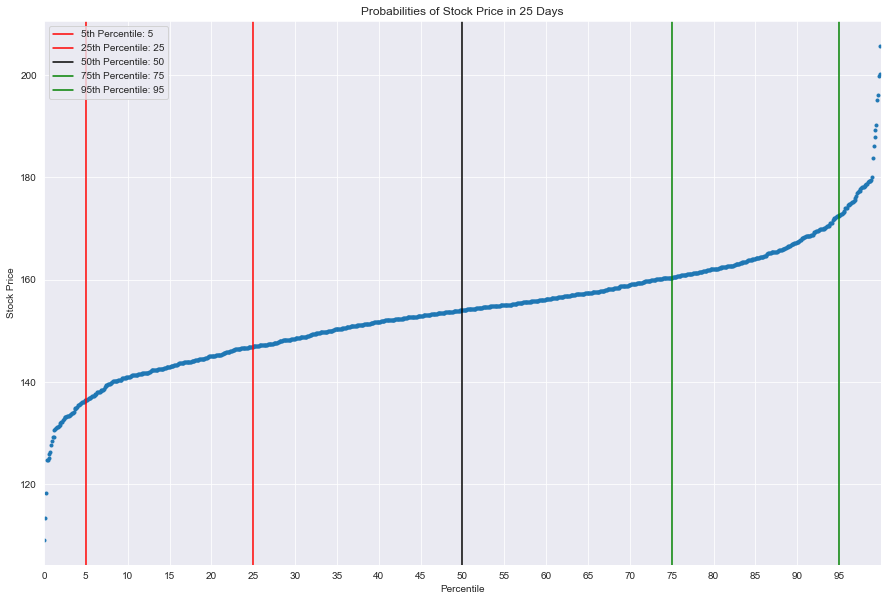

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
fig = probscale.probplot(end_vals, ax=ax, plottype='pp',
                         problabel='Percentile', datalabel='Stock Price',
                         scatter_kws=dict(marker='.', linestyle='none'))

plot_percentile_prices(price_chart=False)
ax.set_xticks(range(0,100,5))
plt.legend(loc='upper left')
plt.title(f'Probabilities of Stock Price in {horizon} Days')
plt.show()